### Prediction of Stock Prices using Random Forest

Using this paper: https://arxiv.org/pdf/1605.00003.pdf
and this github: https://github.com/jmartinezheras/reproduce-stock-market-direction-random-forests/blob/master/2016_StockDirection_RF.ipynb

Use technical indicators from datasets can we use random forest to predict stock market price. More specifically we are trying to predict whether the price will rise or fall using a prediction horizon. In the paper a 10 day 
horizon is used.

In [116]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from finta import TA
import technical_indicators as ta
from useful.eda import basic_info
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score

##### Use yfinance to import data of the stock we are interested in...

In [101]:
stock = yf.download('AAPL')

[*********************100%***********************]  1 of 1 downloaded


##### Select period from 2010-01-04 to 2014-12-10 for analysis

The paper uses a period from 2010-01-04 to 2014-12-10 on apples stock to predict...

In [118]:
df = stock[(stock.index >= '2010-01-04') & (stock.index <= '2014-12-10')]

basic_info.data_info(df,None)

basic info for this dataframe...


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,30.49,30.64,30.34,30.57,26.68,123432400
2010-01-05,30.66,30.80,30.46,30.63,26.73,150476200
2010-01-06,30.63,30.75,30.11,30.14,26.30,138040000
2010-01-07,30.25,30.29,29.86,30.08,26.25,119282800
2010-01-08,30.04,30.29,29.87,30.28,26.43,111902700


Index([], dtype='object')
The number of non-numerical columns is 0
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
The number of numerical columns is 6
missing data/column names....
           0
Volume     0
Adj Close  0
Close      0
Low        0
High       0
Open       0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1244 entries, 2010-01-04 to 2014-12-10
Data columns (total 6 columns):
Open         1244 non-null float64
High         1244 non-null float64
Low          1244 non-null float64
Close        1244 non-null float64
Adj Close    1244 non-null float64
Volume       1244 non-null int64
dtypes: float64(5), int64(1)
memory usage: 68.0 KB
None
              Open         High          Low        Close    Adj Close  \
count  1244.000000  1244.000000  1244.000000  1244.000000  1244.000000   
mean     65.731648    66.324268    65.058875    65.706543    58.358304   
std      21.229333    21.392889    21.058379    21.227193    19.603284   
min      27.

##### Plot the stock price of the four year period...

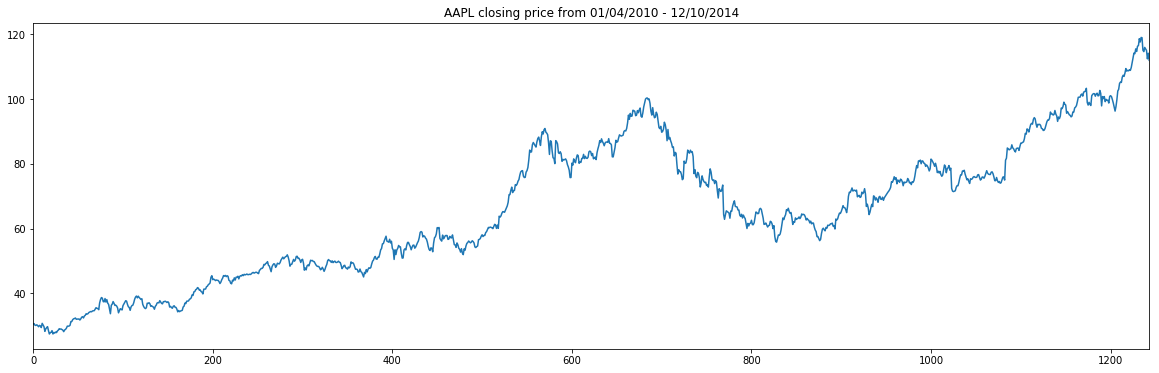

In [120]:
plt.figure(figsize=(20, 6))

sns.tsplot(data=df.loc[:,'Close'])
plt.title('AAPL closing price from 01/04/2010 - 12/10/2014')
plt.show()

##### Use Exponential Smoothing 

Exponential smoothing put more emphasis on recent observations as opposed to older obesrvations. According to the paper exponential smoothing removes noise allowing the model to better identify long term trends.

In [121]:
col_ = ['Open','High','Low','Close','Volume']

df_ = df.loc[:,[c for c in df.columns if c in col_]]

#exponential moving average
df_e = df_.ewm(alpha=0.9).mean()

df_e.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,30.490000,30.640000,30.340000,30.570000,1.234324e+08
2010-01-05,30.644545,30.785455,30.449091,30.624545,1.480177e+08
2010-01-06,30.631441,30.753514,30.143604,30.188018,1.390288e+08
2010-01-07,30.288110,30.336310,29.888335,30.090792,1.212556e+08
2010-01-08,30.064809,30.294631,29.871833,30.261081,1.128379e+08


##### Reset the index because the fxns below don't take datetime as an input...

In [122]:
df_aapl = df_e.reset_index(drop=True); df_aapl.head()

,Open,High,Low,Close,Volume
0,30.490000,30.640000,30.340000,30.570000,1.234324e+08
1,30.644545,30.785455,30.449091,30.624545,1.480177e+08
2,30.631441,30.753514,30.143604,30.188018,1.390288e+08
3,30.288110,30.336310,29.888335,30.090792,1.212556e+08
4,30.064809,30.294631,29.871833,30.261081,1.128379e+08


##### Feature Engineering: Technical Indicators

The inputs used for the data are technical indicators which are calculated using technical_indicators.py from the following github: https://github.com/Crypto-toolbox/pandas-technical-indicators. Everything is put into a dataframe and the target variable (Y) is calculated using the prepare data function and the compute prediction function which sets the prediction horizon. In the paper & github the authors use a 10-day prediction horizon. Not coming from the technical indicators python fucntions are the expontional moving averages. In this case the authors use 5,14,21 & 50 day averges and add them into the dataset. 

The paper uses the prediction as the following formula to predict price on the $i^{th}$ day:

$target_i=Sign(close_{i+d}-close_i )$

where $i$ is the prediction day and $d$ is the number of days in the prediction horizon

The authors state that a 1 indicates positive price change while -1 indicates negative price change. In the code below the function returns a boolean which is translated to a 1 or 0. Quite simple 0 = stock goes up, 1 = stock goes down (in projected horizon).

In [39]:
def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.accumulation_distribution(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.money_flow_index(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.on_balance_volume(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.ease_of_movement(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
        
    #Williams %R is missing
    data = ta.macd(data, n_fast=12, n_slow=26)
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data
   
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close']) #is previous closing price >= than current price return boolean
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon] #drop NaN based on prediction horizon
    data['pred'] = compute_prediction_int(data, n=horizon)
    del(data['Close'])
    return data.dropna()

##### Predict using a 10 day prediction horizon 

In [40]:
data = prepare_data(df_aapl, 10)

y = data['pred']

#remove the output from the input
features = [x for x in data.columns if x not in ['gain', 'pred']]
X = data[features]

##### Take a look at our feature set...

In [46]:
X.head()

,RSI_5,SO%d_5,Acc/Dist_ROC_5,ATR_5,Momentum_5,MFI_5,ROC_5,OBV_5,CCI_5,EoM_5,...,EoM_66,Trix_66,Vortex_66,ema50,ema21,ema14,ema5,MACD_12_26,MACDsign_12_26,MACDdiff_12_26
196,0.940545,0.552863,-2.686592,0.689537,1.559278,1.0,0.037148,1.343347e+08,1.278916,1.182118e-09,...,3.015493e-10,0.000687,0.219355,1.135233,1.088139,1.067289,1.029520,1.173722,1.117987,0.055735
197,0.947580,0.655376,-0.328125,0.575350,1.838928,1.0,0.028981,1.353875e+08,1.165090,1.193451e-09,...,3.728629e-10,0.000717,0.262122,1.140020,1.091105,1.069524,1.030500,1.216323,1.137654,0.078669
198,0.986692,0.760128,-7.940474,0.938132,2.838893,1.0,0.062007,1.473633e+08,1.620894,2.174898e-09,...,4.722065e-10,0.000750,0.287847,1.178594,1.125389,1.101695,1.057062,1.365341,1.183192,0.182150
199,0.990923,0.781169,0.855823,0.870646,3.199889,1.0,0.064868,1.784975e+08,1.393607,2.341785e-09,...,5.153373e-10,0.000785,0.328546,1.189388,1.132884,1.107524,1.058376,1.513228,1.249199,0.264029
200,0.448864,0.752166,-3.284272,1.352108,1.723989,0.8,0.034382,9.028872e+07,0.168664,8.577021e-10,...,4.128378e-10,0.000821,0.280361,1.158382,1.101572,1.076253,1.028277,1.528928,1.305145,0.223783


##### Split the data using 80% training and 20% test

In [47]:
#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

print(X_train.shape)
print(X_test.shape)

(822, 67)
(206, 67)


##### import random forest classifier and train on the data...

In [149]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
rfc = ensemble.RandomForestClassifier(n_estimators=100)

cross_val_score(rfc, X_train, y_train, cv=10)

array([0.79518072, 0.90361446, 0.91566265, 0.86585366, 0.90243902,
       0.86585366, 0.81707317, 0.87804878, 0.87804878, 0.83950617])

In [152]:
rfc.fit(X_train, y_train.values.ravel())

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('')
print(confusion)

              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82        87
         1.0       0.86      0.90      0.88       119

    accuracy                           0.85       206
   macro avg       0.85      0.85      0.85       206
weighted avg       0.85      0.85      0.85       206


[[ 70  17]
 [ 11 108]]


##### results...

Precision: 85-86% of our results that we are returning are relevant
Recall: When the stock is going down on a 10-day forecast horizon our model is classifying 90% of our results accurately, however 79% of the time it is correctly classifying if the stock is going up.  

##### Overlay prediction results v. actual on test set...

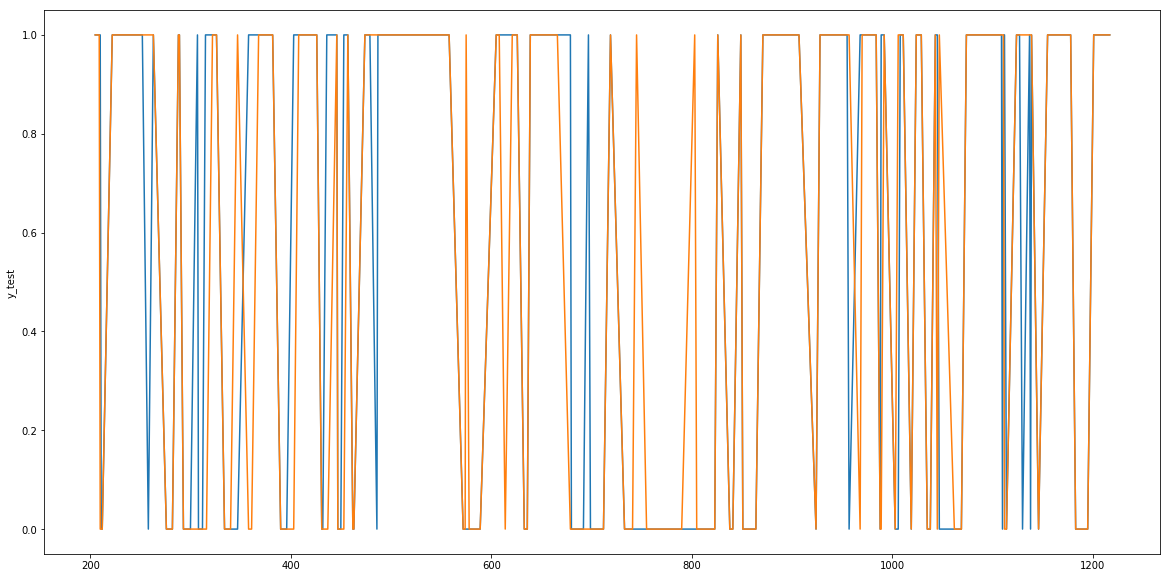

In [173]:
plt.figure(figsize=(20,10))

predictions = pd.DataFrame({'prediction':y_pred,'y_test':y_test})

sns.lineplot(x=predictions.index, y=predictions.prediction,data=predictions)
sns.lineplot(x=predictions.index, y=predictions.y_test,data=predictions)

plt.show()

##### KNN

In [174]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Text(0, 0.5, 'Mean Error')

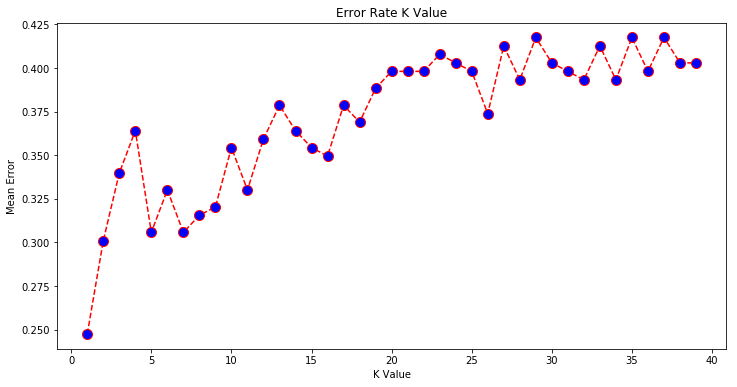

In [175]:
error=[np.mean(
        KNeighborsClassifier(n_neighbors=i).fit(X_train,y_train).predict(X_test)!= y_test) for i in range(1,40)]

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [176]:
neighbors = KNeighborsClassifier(n_neighbors=6)

neighbors.fit(X_train,y_train)
y_pred = neighbors.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.68      0.63        87
         1.0       0.74      0.66      0.70       119

    accuracy                           0.67       206
   macro avg       0.67      0.67      0.67       206
weighted avg       0.68      0.67      0.67       206



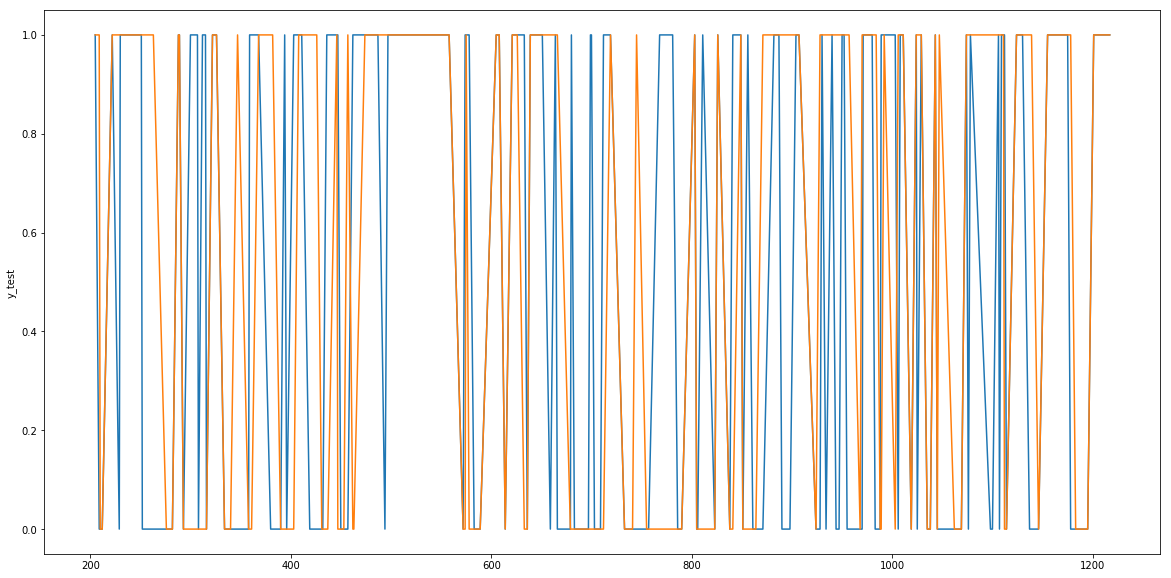

In [177]:
plt.figure(figsize=(20,10))

predictions = pd.DataFrame({'prediction':y_pred,'y_test':y_test})

sns.lineplot(x=predictions.index, y=predictions.prediction,data=predictions)
sns.lineplot(x=predictions.index, y=predictions.y_test,data=predictions)

plt.show()

##### Ordinary Least Squares

In [133]:
import statsmodels.api as sm

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   pred   R-squared (uncentered):                   0.703
Model:                            OLS   Adj. R-squared (uncentered):              0.679
Method:                 Least Squares   F-statistic:                              29.53
Date:                Sun, 20 Oct 2019   Prob (F-statistic):                   6.81e-161
Time:                        14:18:58   Log-Likelihood:                         -445.48
No. Observations:                 822   AIC:                                      1013.
Df Residuals:                     761   BIC:                                      1300.
Df Model:                          61                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------